<a href="https://colab.research.google.com/github/takato100/finalthesis/blob/main/finalthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import uuid
from dataclasses import dataclass
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
@dataclass
class Packet:
    id: uuid.UUID
    user_id: int
    life: int

In [ ]:
# 正規分布に従う乱数生成
def generate_normal_distribution_data(mean, std_dev, size):
    while True:
      data = np.random.normal(mean, std_dev, size)
      if np.all(data >= 0):
        break
    return data

# 指定された範囲でランダムな数を生成
def generate_random_numbers(start, end, count):
    random_numbers = np.random.randint(start, end + 1, count)
    return random_numbers


In [ ]:

def generator(user_ids, ave_user, std_user, ave_packets, std_packets, packet_life):
    """
    packetを作ってqueueに入れるという一回の行為とする．

    input
        user_ids(list) 誰のパケットを生成するか．そのリスト
        ave_user (int) 平均何人が生成するか
        ave_packets 選ばれしUEが平均何個のpacketを生成するか
        packet_life 生成するpacketのlife

    output
        生成したpacket_list.中身はシャッフルされているのでそのまま元queueに結合できる．

    """
    # userを選ぶ
    users_size = int(generate_normal_distribution_data(ave_user, std_user, 1))
    # print(users_size, "users will generate packets")
    users = random.sample(user_ids, users_size)
    # 各userに対して特定個数のpacket生成
    packets = deque()
    for user_id in users:
        packet_size = int(generate_normal_distribution_data(ave_packets, std_packets, 1))
        #print(user_id, "will generate", packet_size, "packets")
        for i in range(packet_size):
            packet = Packet(id=uuid.uuid4(), user_id=user_id, life=int(packet_life))
            packets.append(packet)

    random.shuffle(packets)
    print(len(packets), "packets generated")
    return packets



In [ ]:
@dataclass
class User:
  id: int
  comp: bool
  bs: int


In [ ]:
# userを作る
#service1: bs1(1,2,3,4(comp)) bs2(5(comp),6,7,8)
#service2: bs1(9,10,11,12(comp)) bs2(13(comp),14,15,16)

user1 = User(id=1, comp=0, bs=1)
user2 = User(id=2, comp=0, bs=1)
user3 = User(id=3, comp=0, bs=1)
user4 = User(id=4, comp=1, bs=1)
user5 = User(id=5, comp=1, bs=2)
user6 = User(id=6, comp=0, bs=2)
user7 = User(id=7, comp=0, bs=2)
user8 = User(id=8, comp=0, bs=2)
user9 = User(id=9, comp=0, bs=1)
user10 = User(id=10, comp=0, bs=1)
user11 = User(id=11, comp=0, bs=1)
user12 = User(id=12, comp=1, bs=1)
user13 = User(id=13, comp=1, bs=2)
user14 = User(id=14, comp=0, bs=2)
user15 = User(id=15, comp=0, bs=2)
user16 = User(id=16, comp=0, bs=2)

users = [user1, user2, user3, user4,
         user5, user6, user7, user8,
         user9, user10, user11, user12,
         user13, user14, user15, user16,]

In [ ]:
def rows_of_zeros(matrix):
  # comp可能な行
  # 全てが0である行
  zero_rows = np.all(matrix == 0, axis=1)
  zero_rows_indices = np.where(zero_rows)[0]
  return zero_rows_indices

def is_zero_in_column(matrix, column_index):
  # column_indexで指定したBSに空きがあるかどうか
  return np.any(matrix[:, column_index] == 0)

def rows_with_zeros_in_columns(matrix, column_index):
  # 特定の列において要素が0であるような行番号のリスト
  zero_rows_indices = np.where(matrix[:, column_index] == 0)[0]
  return zero_rows_indices


In [ ]:
def scheduler(queue, max_bw1, max_bw2, grid):
  """
    ここでは　1つのサービスのqueueのみが，与えられたbwを全て使っていいことにする．
    life == 1のものをscheduleすることにする

    利用できる上限量(max_bw)に達したらその時点で，そのBSではリソースを確保することはできない．


    input
      queue(deque): scheduleする必要があるqueue
      max_bw1(int): bs1において利用可能なbw量
      max_bw2(int): bs2において利用可能なbw量
      grid(list): PRBgridを示すmatrix．空いてるgridが0
  """
  global users
  global monitor_dead_packets


  # 残りbw
  bw = [max_bw1, max_bw2]
  # scheduleしたpacketでlifeが0以下だったもの
  dead_packets = 0
  # よびキュー
  s_queue = deque()

  while not (bw[0] == 0 and bw[1] == 0) and len(queue) > 0:
    p = queue[0]
    comp = [u.comp for u in users if u.id == p.user_id]
    bs = [u.bs for u in users if u.id == p.user_id]

    if p.life > 1:
      #print("life > 1")
      break

    # compなし
    elif comp[0] == 0:
      slots = rows_with_zeros_in_columns(grid, bs[0] - 1)
      if bw[bs[0] - 1] == 0:
        #print("!sched error! bs", bs[0], "reached to max bw")
        s_queue.append(queue.popleft())
      elif  len(slots) == 0:
        #print("!sched error! no available prb in bs", bs[0])
        s_queue.append(queue.popleft())
      else:
        p = queue.popleft()
        # deadなら記録
        if p.life <= 0:
          dead_packets += 1
        # grid更新
        grid[slots[0], bs[0] - 1] = 1
        # 残りbw更新
        bw[bs[0] - 1] -= 1
        """
        print(grid)
        print("scheduled!(no comp)")
        print("left bw: ", bw[0], ",", bw[1])
        print("-----")
        """

    # compあり
    elif comp[0] == 1:
      slots = rows_of_zeros(grid)
      if bw[0] == 0 or bw[1] == 0:
        #print("!sched error! bs1 or bs2 reached bw limit (comp)")
        s_queue.append(queue.popleft())
      elif len(slots) == 0:
        #print("!sched error! no slots available for comp")
        s_queue.append(queue.popleft())
      else:
        p = queue.popleft()
        # dead
        if p.life <= 0:
          dead_packets += 1
        # grid更新
        grid[slots[0], :] = 1
        # bw更新
        bw[0] -= 1
        bw[1] -= 1
        """
        print(grid)
        print("scheduled!(comp)")
        print("left bw: ", bw[0], ",", bw[1])
        print("-----")
        """

  #print("-- TTI fin --")
  #print("dead = ", dead_packets)
  monitor_dead_packets.append(dead_packets)
  #print("s_queue = ", s_queue)
  return s_queue


In [ ]:
# main
monitor_dead_packets = []
monitor_queue_len = []
queue = deque()


for i in range(1000):
  monitor_queue_len.append(len(queue))
  if len(queue) != 0:
    spare = scheduler(queue, 8, 5, np.zeros((10, 2)))
    # 予備キューを先頭に追加
    for i in reversed(spare):
      queue.appendleft(i)
    # decrease life
    for p in queue:
      p.life -= 1
  # packet add
  for p in generator([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], ave_user = 3, std_user = 0.5, ave_packets = 4, std_packets = 1, packet_life = 1):
    queue.append(p)


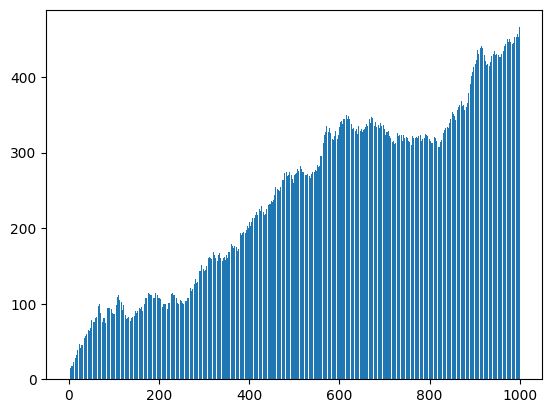

In [ ]:
x = []
for i in range(len(monitor_queue_len)):
  x.append(i)

plt.bar(x, monitor_queue_len)
plt.show()